In [1]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib_inline import backend_inline
from IPython import display
import ast
from wordcloud import WordCloud
from urllib.parse import unquote
from utils import calculate_CR, calculate_NDCG, recommend_N, calculate_popularity, calculate_Gini, calculate_popular_track_ratio

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

track_count_df = pd.read_csv('../data/track_count.csv')

track_playcount_list = track_count_df['playcount'].tolist()
track_user_count_list = track_count_df['user_count'].tolist()

num_tracks = track_count_df['serial_number'].max() + 1
print(f'{num_tracks} tracks in filtered data')

user_events_file = '../data/topic_model_train.csv'
user_events_df = pd.read_csv(user_events_file)
user_events_list = []

user_listen_count_list = user_events_df['listen_count_intensity'].tolist()

for index, row in user_events_df.iterrows():
    listen_list = ast.literal_eval(row['train_set'])
    user_events_list.append(listen_list)

predict_candidate_df = pd.read_csv('../data/predict_performance_test.csv')
predict_candidate_list = []
for index, row in predict_candidate_df.iterrows():
    row_list = ast.literal_eval(row['test_set'])
    predict_candidate_list.append(row_list)

num_users = len(predict_candidate_df)
print(f'{num_users} users in filtered data')

max_length = max([len(user_lists) for user_lists in user_events_list])
min_length = min([len(user_lists) for user_lists in user_events_list])
print('max_length = ', max_length)
print('min_length = ', min_length)

146910 tracks in filtered data
21245 users in filtered data
max_length =  989
min_length =  4


In [3]:
track_name_list = track_count_df['name'].tolist()

def parse_and_truncate_names(name_list):
    parsed_names = []

    for name in name_list:
        name_without_plus = name.replace('+', '')
        decoded_name = unquote(name_without_plus)
        artist, song = decoded_name.split('/_/')
        truncated_artist = artist[:14]
        truncated_song = song[:14]
        formatted_name = f"{truncated_artist}:{truncated_song}"
        parsed_names.append(formatted_name)
    
    return parsed_names

parsed_name_list = parse_and_truncate_names(track_name_list)

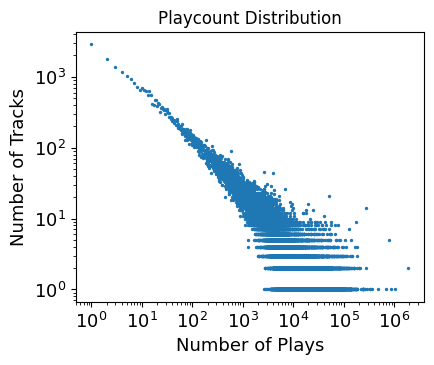

In [5]:
playcounts = track_playcount_list

df_playcounts = pd.DataFrame({'playcount': playcounts})
playcount_dict = df_playcounts.playcount.value_counts().to_dict()

plt.figure(figsize=(4.5, 3.5), dpi=100)
plt.scatter(list(playcount_dict.keys()), list(playcount_dict.values()), s=2)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Playcount Distribution')
plt.xlabel('Number of Plays', fontsize=13)
plt.ylabel('Number of Tracks', fontsize=13)
plt.show()

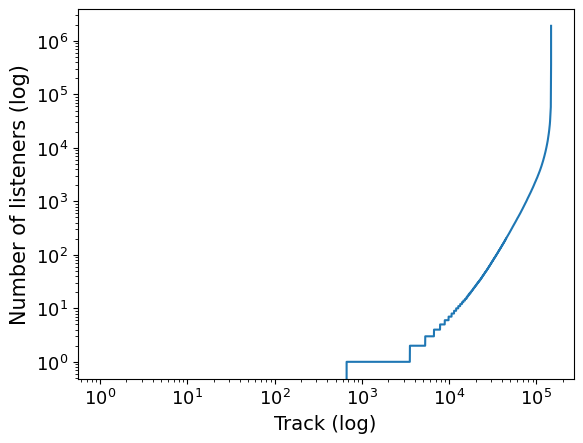

In [7]:
plt.figure()
plt.plot(sorted(track_playcount_list))
plt.xlabel('Track (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of listeners (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')

In [10]:
playcounts_series = pd.Series(playcounts)

playcount_stats = playcounts_series.describe()

print(f'playcount_stats:\n{playcount_stats}')

playcount_stats:
count    1.469100e+05
mean     4.578929e+03
std      1.464091e+04
min      0.000000e+00
25%      1.170000e+02
50%      8.820000e+02
75%      3.893000e+03
max      1.918184e+06
dtype: float64


In [11]:
def use_svg_display():
    #@save
    backend_inline.set_matplotlib_formats('svg')
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
class Animator:
    #@save
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
def mu_batch_generator(wordOccuranceMatrix, rho_matrix, eta_matrix, n, V):
    flattened_wordOccuranceMatrix = wordOccuranceMatrix.view(-1)
    flattened_rho_matrix = rho_matrix.view(-1)
    flattened_eta_matrix = eta_matrix.contiguous().view(-1, eta_matrix.shape[-1])

    for i in range(0, wordOccuranceMatrix.numel(), n):
        indices = flattened_wordOccuranceMatrix[i:i+n]
        current_batch_size = indices.shape[0]
        
        y = torch.zeros(current_batch_size, V, device=device)
        y.scatter_(1, indices.unsqueeze(1), 1)
        
        vector_batch = flattened_rho_matrix[i:i+current_batch_size]
        tensor_batch = flattened_eta_matrix[i:i+current_batch_size]
        
        yield torch.einsum('nv, n, nk -> kv', [y, vector_batch, tensor_batch])

def sigma_batch_generator(wordOccuranceMatrix, rho_matrix, n, V):
    flattened_wordOccuranceMatrix = wordOccuranceMatrix.view(-1)
    flattened_rho_matrix = rho_matrix.view(-1)

    for i in range(0, wordOccuranceMatrix.numel(), n):
        indices = flattened_wordOccuranceMatrix[i:i+n]
        current_batch_size = indices.shape[0]  

        y = torch.zeros(current_batch_size, V, device=device)
        y.scatter_(1, indices.unsqueeze(1), 1)
        
        vector_batch = flattened_rho_matrix[i:i+current_batch_size]
        
        yield torch.einsum('nv, n -> v', [y, vector_batch])

In [13]:
class HBLDA:
    def __init__(self, num_topics, alpha, beta, gamma, zeta, delta, cq, random_state, mu_batch, sigma_batch, num_tracks, predict_candidate_list):
        self.predict_candidate_list = predict_candidate_list
        self.num_topics = num_topics
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.zeta = zeta
        self.delta = delta

        self.num_words = torch.tensor(num_tracks, device=device, dtype=torch.int32)
        self.cq = torch.tensor(cq, dtype=torch.float32, device=device)

        self.random_state = random_state
        self.mu_batch = mu_batch
        self.sigma_batch = sigma_batch

        np.random.seed(self.random_state)
        torch.manual_seed(self.random_state)
        if torch.cuda.is_available(): 
            torch.cuda.manual_seed(self.random_state)
            torch.cuda.manual_seed_all(self.random_state)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
    def processProfiles(self, user_events_list, user_count_list):
        self.Nu = torch.tensor([len(user_list) for user_list in user_events_list], device=device, dtype=torch.int32)
        self.num_docs = torch.tensor(len(user_events_list), device=device, dtype=torch.int32)
        self.num_intensity = torch.tensor(max(user_count_list) + 1, device=device, dtype=torch.int32)
        self.max_len = torch.max(self.Nu).to(device).to(torch.int32)
        
        self.alpha = self.alpha * torch.ones(self.num_topics, device=device)
        self.beta = self.beta * torch.ones(self.num_words, device=device)
        self.gamma = torch.tensor(self.gamma, device=device)
        self.zeta = self.zeta * torch.ones(self.num_words, device=device)
        self.delta = self.delta * torch.ones(self.num_intensity, device=device)

        self.mask = torch.tensor([[1] * len(user_list) + [0] * (self.max_len - len(user_list)) for user_list in user_events_list], dtype=torch.bool, device=device)

        self.tau = (torch.distributions.Gamma(100.0, 0.01).sample((self.num_docs, self.num_topics))).to(device)
        eta = torch.einsum('unk, un -> unk', [torch.distributions.Dirichlet(torch.ones(self.num_docs, self.max_len, self.num_topics)).sample().to(device), self.mask])
        self.eta = eta.to('cuda:1')
        del eta
        torch.cuda.empty_cache()
        
        self.rho = (torch.einsum('un, un -> un', [torch.distributions.Beta(torch.ones(self.num_docs, self.max_len), torch.ones(self.num_docs, self.max_len)).sample().to(device), self.mask]))
        self.lamda = torch.distributions.Gamma(100.0, 0.01).sample((self.num_docs, 2)).to(device)
        self.iota = torch.distributions.Beta(torch.ones(self.num_docs), torch.ones(self.num_docs)).sample().to(device)
        self.mu = torch.distributions.Gamma(100.0, 0.01).sample((self.num_topics, self.num_words)).to(device)
        self.sigma = torch.distributions.Gamma(100.0, 0.01).sample((self.num_words, )).to(device)
        self.kappa = torch.distributions.Gamma(100.0, 0.01).sample((2, self.num_intensity)).to(device)
        self.wordOccuranceMatrix = torch.tensor([user_list + [0] * (self.max_len - len(user_list)) for user_list in user_events_list], dtype=torch.int64) # NOTE: Fill it with 0 because it will be indexed late
        self.user_count_list = torch.tensor(user_count_list, device=device)

        self.ELBO = []
    
    def ref_update_variational_parameters(self):
        mu_kun = torch.stack([self.mu[k].index_select(0, self.wordOccuranceMatrix.view(-1).to(device)).view(self.wordOccuranceMatrix.shape) for k in range(self.num_topics)])
        self.mu_kun = mu_kun.to('cuda:1')
        del mu_kun
        torch.cuda.empty_cache()

        self.sigma_un = self.sigma[self.wordOccuranceMatrix]
        self.kappa_u = self.kappa[:, self.user_count_list]
        
        for iter in range(50):
            self.tau = torch.einsum('unk -> uk', [self.eta.to('cuda:0')]) + self.alpha

            eta_factor1 = (torch.digamma(self.tau) - torch.digamma(torch.sum(self.tau, dim=1)).unsqueeze(1)).unsqueeze(1) 
            # eta_factor2 = torch.einsum('un, unk -> unk', [(1 - self.rho) * self.mask, torch.digamma(self.mu_kun).to('cuda:0').permute(1, 2, 0) - torch.digamma(torch.sum(self.mu, dim=1))]) # u*n*k
            
            eta_factor2 =torch.zeros((self.num_docs, self.max_len, self.num_topics), device='cuda:0')
            for start in range(0, self.num_topics, 25):
                end = min(start + 25, self.num_topics)

                mu_kun_chunk = self.mu_kun[start:end, :, :]
                mu_chunk = self.mu[start:end, :]

                mu_kun_permuted = torch.digamma(mu_kun_chunk).permute(1, 2, 0).to('cuda:0')

                digamma_mu_sum = torch.digamma(torch.sum(mu_chunk, dim=1))

                eta_factor2[:, :, start:end] = torch.einsum(
                    'un, unk -> unk', 
                    [(1 - self.rho) * self.mask, mu_kun_permuted - digamma_mu_sum]
                )
            
            shifted_matrix = eta_factor1 + eta_factor2 - torch.max(eta_factor1 + eta_factor2, dim=2)[0].unsqueeze(2)
            del eta_factor1, eta_factor2
            eta = torch.einsum('unk, un -> unk', [torch.exp(shifted_matrix).div_(torch.exp(shifted_matrix).sum(dim=-1, keepdim=True)), self.mask])
            self.eta = eta.cpu()
            del eta, shifted_matrix
            torch.cuda.empty_cache()

            rho_factor1 = -(torch.digamma(self.sigma_un) * self.mask) + torch.digamma(torch.sum(self.sigma)) # u*n
            # rho_factor2 = torch.einsum('unk, unk -> un', [self.eta.to('cuda:0'), torch.digamma(self.mu_kun).to('cuda:0').permute(1, 2, 0) - torch.digamma(torch.sum(self.mu, dim=1))]) # u*n
            
            rho_factor2 = torch.zeros((self.num_docs, self.max_len), device='cuda:0')
            for start in range(0, self.num_topics, 25):
                end = min(start + 25, self.num_topics)

                eta_unk_chunk = self.eta.to('cuda:0')[:, :, start:end]
                mu_kun_chunk = self.mu_kun[start:end, :, :]
                mu_chunk = self.mu[start:end, :]

                mu_kun_permuted = torch.digamma(mu_kun_chunk).permute(1, 2, 0).to('cuda:0')

                digamma_mu_sum = torch.digamma(torch.sum(mu_chunk, dim=1))

                rho_factor2 += torch.einsum(
                    'unk, unk -> un', 
                    [eta_unk_chunk, mu_kun_permuted - digamma_mu_sum]
                )

            rho_factor3 = (torch.digamma(self.lamda[: , 1]) - torch.digamma(self.lamda[: , 0])).unsqueeze(1) 
            exp_sum_rho_factor = torch.exp(rho_factor1 + rho_factor2 + rho_factor3)
            del rho_factor1, rho_factor2, rho_factor3
            self.rho = torch.einsum('un, un -> un', [1 / (1 + exp_sum_rho_factor), self.mask])
            del exp_sum_rho_factor
            torch.cuda.empty_cache()

            self.lamda = torch.stack((torch.sum(self.rho, dim=1) + self.iota + self.gamma[0], torch.sum((1 - self.rho) * self.mask, dim=1) + 1 - self.iota + self.gamma[1])).T

            iota_factor1 = -torch.digamma(self.lamda[:, 0]) + torch.digamma(self.lamda[:, 1])
            iota_factor2 = torch.digamma(self.kappa_u[0, :]) - torch.digamma(self.kappa_u[1, :])
            iota_factor3 = -torch.digamma(torch.sum(self.kappa[0])) + torch.digamma(torch.sum(self.kappa[1]))
            exp_sum_iota_factor = torch.exp(iota_factor1 + iota_factor2 + iota_factor3)
            self.iota = 1 / (1 + exp_sum_iota_factor)
            del iota_factor1, iota_factor2, iota_factor3, exp_sum_iota_factor
            torch.cuda.empty_cache()

        self.mu = torch.ones(self.num_topics, self.num_words, device=device) * self.beta
        for tmp_mu in mu_batch_generator(self.wordOccuranceMatrix.to(device), (1 - self.rho) * self.mask, self.eta.to('cuda:0'), self.mu_batch, self.num_words):
            self.mu += tmp_mu

        self.sigma = self.cq + self.zeta
        for tmp_sigma in sigma_batch_generator(self.wordOccuranceMatrix.to(device), self.rho, self.sigma_batch, self.num_words):
            self.sigma += tmp_sigma

        uf_matrix = torch.zeros((self.num_docs, self.num_intensity), device=device)
        uf_matrix.scatter_(1, self.user_count_list.unsqueeze(1), 1)
        self.kappa[0] = self.delta + torch.einsum('u, uf -> f', [1 - self.iota, uf_matrix])
        self.kappa[1] = self.delta + torch.einsum('u, uf -> f', [self.iota, uf_matrix])
        del uf_matrix
        torch.cuda.empty_cache()

    def calculate_ELBO(self):
        factor = torch.zeros(20)

        factor[1] = 2 * torch.lgamma(torch.sum(self.delta)) - 2 * torch.sum(torch.lgamma(self.delta)) + torch.einsum('f, if -> ', [self.delta - 1, torch.digamma(self.kappa) - torch.digamma(torch.sum(self.kappa, dim=1)).unsqueeze(1)])

        factor[2] = (self.num_docs * torch.lgamma(torch.sum(self.gamma)) 
                     - self.num_docs * torch.sum(torch.lgamma(self.gamma)) 
                     + torch.einsum('i, ui -> ', [self.gamma - 1, torch.digamma(self.lamda) - torch.digamma(torch.sum(self.lamda, dim=1)).reshape(self.num_docs, 1)]))
        
        factor[3] = (self.num_docs * torch.lgamma(torch.sum(self.alpha)) 
                     - self.num_docs * torch.sum(torch.lgamma(self.alpha)) 
                     + torch.einsum('k, uk -> ', [self.alpha - 1, torch.digamma(self.tau) - torch.digamma(torch.sum(self.tau, dim=1)).reshape(self.num_docs, 1)]))

        factor[4] = (self.num_topics * torch.lgamma(torch.sum(self.beta)) 
                     - self.num_topics * torch.sum(torch.lgamma(self.beta)) 
                     + torch.einsum('v, kv -> ', [self.beta - 1, torch.digamma(self.mu) - torch.digamma(torch.sum(self.mu, dim=1)).reshape(self.num_topics, 1)]))
        
        factor[5] = (torch.lgamma(torch.sum(self.zeta))
                     - torch.sum(torch.lgamma(self.zeta))
                     + torch.einsum('v, v -> ', [self.zeta - 1, torch.digamma(self.sigma) - torch.digamma(torch.sum(self.sigma))]))
        
        factor[6] = torch.einsum('v, v -> ', [self.cq, torch.digamma(self.sigma) - torch.digamma(torch.sum(self.sigma))])

        factor[7] = torch.sum((1 - self.iota) * (torch.digamma(self.lamda[:, 1]) - torch.digamma(torch.sum(self.lamda, dim=1))) 
                              + self.iota * (torch.digamma(self.lamda[:, 0]) - torch.digamma(torch.sum(self.lamda, dim=1))))

        factor[8] = torch.sum((1 - self.iota) * (torch.digamma(self.kappa_u[0]) - torch.digamma(torch.sum(self.kappa[0]))) 
                              + self.iota * (torch.digamma(self.kappa_u[1]) - torch.digamma(torch.sum(self.kappa[1]))))
        
        factor9_1 = torch.einsum('un, u -> ', [(1 - self.rho) * self.mask, torch.digamma(self.lamda[: , 1]) - torch.digamma(torch.sum(self.lamda, dim=1))])
        factor9_2 = torch.einsum('un, u -> ', [self.rho, torch.digamma(self.lamda[: , 0]) - torch.digamma(torch.sum(self.lamda, dim=1))])
        factor[9] = factor9_1 + factor9_2

        factor[10] = torch.einsum('unk, uk -> ', [self.eta, torch.digamma(self.tau) - torch.digamma(torch.sum(self.tau, dim=1)).reshape(self.num_docs, 1)])
        
        factor11_1 = torch.einsum('un, unk, unk -> ', 
                                 [(1 - self.rho) * self.mask, 
                                  self.eta, 
                                  self.mask.view(self.num_docs, self.max_len, 1) * (torch.einsum('kun -> unk', [torch.digamma(self.mu_kun)]) - torch.digamma(torch.sum(self.mu, dim=1)))])
        factor11_2 = torch.einsum('un, un -> ', 
                                 [self.rho, 
                                  torch.digamma(self.sigma_un) * self.mask - torch.digamma(torch.sum(self.sigma))])
        factor[11] = factor11_1 + factor11_2

        factor[12] = (-torch.sum(torch.lgamma(torch.sum(self.mu, dim=1))) 
                      + torch.sum(torch.lgamma(self.mu)) 
                      - torch.einsum('kv, kv -> ', [self.mu - 1, torch.digamma(self.mu) - torch.digamma(torch.sum(self.mu, dim=1)).reshape(self.num_topics, 1)]))

        factor[13] = (-torch.sum(torch.lgamma(torch.sum(self.tau, dim=1))) 
                      + torch.sum(torch.lgamma(self.tau)) 
                      - torch.einsum('uk, uk -> ', [self.tau - 1, torch.digamma(self.tau) - torch.digamma(torch.sum(self.tau, dim=1)).reshape(self.num_docs, 1)]))

        factor[14] = -torch.einsum('unk, unk -> ', [self.eta, torch.where(self.eta > 0, torch.log(self.eta), torch.zeros_like(self.eta))])

        factor[15] = (-torch.sum(torch.lgamma(torch.sum(self.sigma))) 
                      + torch.sum(torch.lgamma(self.sigma)) 
                      - torch.einsum('v, v -> ', [self.sigma - 1, torch.digamma(self.sigma) - torch.digamma(torch.sum(self.sigma))]))
        
        factor[16] = -(torch.einsum('un, un -> ', [(1 - self.rho) * self.mask, torch.where((1 - self.rho) * self.mask > 0, torch.log((1 - self.rho) * self.mask), torch.zeros_like(self.rho))]) 
                       + torch.einsum('un, un -> ', [self.rho, torch.where(self.rho * self.mask > 0, torch.log(self.rho * self.mask), torch.zeros_like(self.rho))]))
        
        factor[17] = (-torch.sum(torch.lgamma(torch.sum(self.lamda, dim=1))) 
                      + torch.sum(torch.lgamma(self.lamda)) 
                      - torch.einsum('ui, ui -> ', [self.lamda - 1, torch.digamma(self.lamda) - torch.digamma(torch.sum(self.lamda, dim=1)).reshape(self.num_docs, 1)]))

        factor[18] = -torch.sum((1 - self.iota) * torch.log(1 - self.iota) + self.iota * torch.log(self.iota))

        factor[19] = -torch.sum(torch.lgamma(torch.sum(self.kappa, dim=1))) + torch.sum(torch.lgamma(self.kappa)) - torch.einsum('if, if -> ', [self.kappa - 1, torch.digamma(self.kappa) - torch.digamma(torch.sum(self.kappa, dim=1)).unsqueeze(1)])
        
        return torch.sum(factor).item()

    def train_model(self, user_events_list, user_count_list, iter_times, is_draw_ELBO=False):
        self.iter_times = iter_times
        self.processProfiles(user_events_list, user_count_list)
        self.less_7_cold_start_users_list = [index for index, sublist in enumerate(user_events_list) if len(sublist) <= 7]
        self.less_10_cold_start_users_list = [index for index, sublist in enumerate(user_events_list) if len(sublist) <= 10]
        self.less_15_cold_start_users_list = [index for index, sublist in enumerate(user_events_list) if len(sublist) <= 15]
        if is_draw_ELBO:
            animator = Animator(xlabel='epoch', xlim=[1, iter_times],legend=['ELBO'])
            for iter in range(self.iter_times):
                self.ref_update_variational_parameters()
                self.ELBO.append(self.calculate_ELBO())
                animator.add(iter, self.ELBO[iter])
        else:
            for iter in tqdm(range(self.iter_times)):
                self.ref_update_variational_parameters()
    
    def predict(self, top_n):
        normalized_mu = self.mu / torch.sum(self.mu, dim=1, keepdim=True)
        normalized_lamda = self.lamda / torch.sum(self.lamda, dim=1).unsqueeze(dim=1)
        normalized_sigma = self.sigma / torch.sum(self.sigma)
        normalized_tau = self.tau / torch.sum(self.tau, dim=1).unsqueeze(dim=1)

        # item_probability_matrix = torch.einsum('u, uk, kv -> uv', [normalized_lamda[:, 1], normalized_tau, normalized_mu]) + torch.einsum('u, v -> uv', [normalized_lamda[:, 0], normalized_sigma])

        item_probability_matrix = torch.einsum('u, uk, kv -> uv', [normalized_lamda[:, 1].to('cpu'), normalized_tau.to('cpu'), normalized_mu.to('cpu')])
        del normalized_tau, normalized_mu
        torch.cuda.empty_cache() 

        # item_probability_matrix += torch.einsum('u, v -> uv', [normalized_lamda[:, 0], normalized_sigma])
        item_probability_matrix += torch.ger(normalized_lamda[:, 0].to('cpu'), normalized_sigma.to('cpu'))
        del normalized_lamda, normalized_sigma
        torch.cuda.empty_cache()

        all_users_predictions = recommend_N(item_probability_matrix, self.predict_candidate_list, top_n)
        return all_users_predictions
    
    def evaluate(self, track_count_list, top_n_predict_list):
        print(f'CR@{len(top_n_predict_list[0])} = ', calculate_CR(top_n_predict_list, self.predict_candidate_list))
        print(f'NDCG@{len(top_n_predict_list[0])} = ', calculate_NDCG(top_n_predict_list, self.predict_candidate_list))

        top_1_recommend_list = [recommend_list_for_one_user[0] for recommend_list_for_one_user in top_n_predict_list]
        popularity = calculate_popularity(torch.tensor(track_count_list, ), top_1_recommend_list)
        print(f'the populairity of recommend result: {popularity}')

In [15]:
K = 

alpha = 
beta = 
gamma = 
zeta = 
delta = 

save_result = 

iter_times = 
random_state = 
mu_batch = 
sigma_batch = 
top_n = 

In [ ]:
myHBLDA = HBLDA(K, alpha, beta, gamma, zeta, delta, track_playcount_list, random_state, mu_batch, sigma_batch, num_tracks, predict_candidate_list)
myHBLDA.train_model(user_events_list, user_listen_count_list, iter_times, False)
predictions = myHBLDA.predict(top_n)
myHBLDA.evaluate(track_user_count_list, predictions)